## 환경
1. gpu
2. 고용량 RAM

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7013291602861587498,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3660972032
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9219915194995578608
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"]

## dacon 빛번짐 제거

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import os
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
import zipfile

### 데이터 불러오기

In [3]:
train_csv = pd.read_csv('D:/dacon_ai_data/train.csv')
test_csv = pd.read_csv('D:/dacon_ai_data/test.csv')

In [4]:
train_csv.head()

,img_id,input_img,label_img
0,10000,train_input_10000.png,train_label_10000.png
1,10001,train_input_10001.png,train_label_10001.png
2,10002,train_input_10002.png,train_label_10002.png
3,10003,train_input_10003.png,train_label_10003.png
4,10004,train_input_10004.png,train_label_10004.png


In [5]:
test_csv.head()

,img_id,input_img,submission_name
0,20000,test_input_20000.png,test_20000.png
1,20001,test_input_20001.png,test_20001.png
2,20002,test_input_20002.png,test_20002.png
3,20003,test_input_20003.png,test_20003.png
4,20004,test_input_20004.png,test_20004.png


In [6]:
train_all_input_files = 'D:/dacon_ai_data/train_input_img/' + train_csv['input_img']
train_all_label_files = 'D:/dacon_ai_data/train_label_img/' + train_csv['label_img']

In [7]:
len(train_all_input_files), len(train_all_label_files)

(622, 622)

In [8]:
train_all_input_files[0], train_all_label_files[0]

('D:/dacon_ai_data/train_input_img/train_input_10000.png',
 'D:/dacon_ai_data/train_label_img/train_label_10000.png')

In [9]:
train_input_files = train_all_input_files[120:].to_numpy()
train_label_files = train_all_label_files[120:].to_numpy()

val_input_files = train_all_input_files[60:120].to_numpy()
val_label_files = train_all_label_files[60:120].to_numpy()

test_input_files = train_all_input_files[:60].to_numpy()
test_label_files = train_all_label_files[:60].to_numpy()

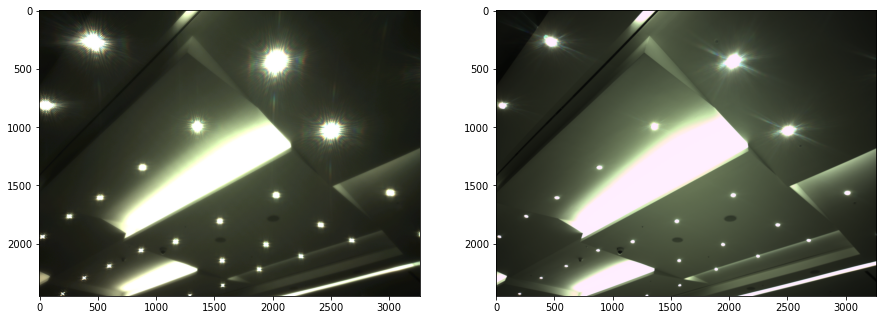

D:/dacon_ai_data/train_input_img/train_input_10120.png D:/dacon_ai_data/train_label_img/train_label_10120.png 



In [10]:
for input_path, label_path in zip(train_input_files, train_label_files):
  inp_img = cv2.imread(input_path)
  targ_img = cv2.imread(label_path)
  plt.figure(figsize=(15, 10))
  inp_img = cv2.cvtColor(inp_img, cv2.COLOR_BGR2RGB)
  targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
  plt.subplot(1, 2, 1)
  plt.imshow(inp_img)
  plt.subplot(1, 2, 2)
  plt.imshow(targ_img)
  plt.show()
  print(input_path, label_path, '\n')
  break

### 하이퍼파라미터

In [11]:
BATCH_SIZE = 8
img_size = 256
weights = 'imagenet'
learning_rate = 1e-4
EPOCHS = 5
dropout_rate = 0.1

### 데이터 전처리

In [12]:
def cut_img(img_path_list, save_path, stride):
  os.makedirs(f'{save_path}{img_size}', exist_ok=True)
  num = 0
  for path in tqdm(img_path_list):
    img = cv2.imread(path)
    for top in range(0, img.shape[0], stride):
      for left in range(0, img.shape[1], stride):
        piece = np.zeros([img_size, img_size, 3], np.uint8)
        temp = img[top:top + img_size, left:left + img_size, :]
        piece[:temp.shape[0], :temp.shape[1], :] = temp
        np.save(f'{save_path}{img_size}/{num}.npy', piece)
        num += 1 # 이미지 갯수가 확 증폭, 128단위로 넘겨서 이미지 잘라서 저장 

In [ ]:
cut_img(train_input_files, 'D:/dacon_ai_data/train_input_img_', 128)
cut_img(train_label_files, 'D:/dacon_ai_data/train_label_img_', 128)
cut_img(val_input_files, 'D:/dacon_ai_data/val_input_img_', 128)
cut_img(val_input_files, 'D:/dacon_ai_data/val_label_img_', 128)

In [ ]:
train_inp_files = glob(f'D:/dacon_ai_data/train_input_img_{img_size}/*.npy')
train_targ_files = glob(f'D:/dacon_ai_data/train_label_img_{img_size}/*.npy')

val_inp_files = glob(f'D:/dacon_ai_data/val_input_img_{img_size}/*.npy')
val_targ_files = glob(f'D:/dacon_ai_data/val_label_img_{img_size}/*.npy')

In [ ]:
train_inp_files, train_targ_files = shuffle(train_inp_files, train_targ_files, random_state = 42)

In [ ]:
len(train_inp_files), len(val_inp_files), len(train_targ_files), len(val_targ_files)

### 데이터 셋

In [ ]:
def train_map_func(inp_path, targ_path):
  inp = np.load(inp_path)
  inp = inp.astype(np.float32) / 255
  targ = np.load(targ_path)
  targ = targ.astype(np.float32) / 255
  inp, targ = augmentation(inp, targ)

  return inp, targ

In [ ]:
def val_map_func(inp_path, targ_path):
  inp = np.load(inp_path)
  inp = inp.astype(np.float32) / 255
  targ = np.load(targ_path)
  targ = targ.astype(np.float32) / 255

  return inp, targ

In [ ]:
def augmentation(inp, targ):
  inp, targ = random_rot(inp, targ)
  inp, targ = random_flip(inp, targ)

  return inp, targ

In [ ]:
def random_rot(inp, targ):
  k = np.random.randint(4)
  inp = np.rot90(inp, k)
  targ = np.rot90(targ, k)

  return inp, targ

In [ ]:
def random_flip(inp, targ):
  f = np.random.randint(2)
  if f == 0: 
    inp = np.fliplr(inp)
    targ = np.fliplr(targ)

  return inp, targ

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_inp_files, train_targ_files))
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_inp_files, val_targ_files))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(val_map_func, [item1, item2], [tf.float32, tf.float32]), num_parallel_calls = tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [ ]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape, next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

### custon loss function
* Mix MS-SSIM + L1 loss
* [출처](https://github.com/sguarnaccio/MSSSIM-ResidualAutoencoder/blob/master/networkUtils.py)

In [ ]:
from tensorflow.keras import backend as K

In [ ]:
sigma = [0.5, 1, 2, 4, 8]
num_scale = 5
alpha = 0.84
beta = 0.0
C1 = 0.01**2
C2 = 0.03**2
filterWidth = 11
inChannel = 3

steps = 16

In [ ]:
def GaussianFilter(num_scale, filterWidth, inChannel):
  w = np.empty((filterWidth*2, filterWidth*2, inChannel, num_scale))
  for i in range(num_scale):
    gaussian = np.exp(-1.*(np.arange(-(filterWidth//2), filterWidth//2 + 1)**2)/(2*sigma[i]**2))
    gaussian = np.outer(gaussian, gaussian.reshape((filterWidth, 1)))
    gaussian = gaussian/np.sum(gaussian)
    gaussian = np.tile(gaussian, (2, 2))
    gaussian = np.reshape(gaussian, (filterWidth*2, filterWidth*2, 1))
    gaussian = np.tile(gaussian, (1, 1, inChannel))
    w[:, :, :, i] = gaussian

  w = tf.convert_to_tensor(w, dtype=tf.float32)
  return w

In [ ]:
gaussianFilter = GaussianFilter(num_scale, filterWidth, inChannel)

In [ ]:
def loss_MS_SSIM_L1(y_true, y_pred):
  y_true_ = K.stack([y_true, y_true, y_true, y_true, y_true], axis=4)
  y_pred_ = K.stack([y_pred, y_pred, y_pred, y_pred, y_pred], axis=4)

  mux = tf.nn.convolution(y_pred, gaussianFilter, padding="VALID", strides=[10, 10], data_format="NHWC")
  mux = K.sum(mux, axis=[1, 2], keepdims=True) / 16
  mux = K.expand_dims(mux, axis=3)
  y_pred_ = y_pred_ - mux

  muy = tf.nn.convolution(y_true, gaussianFilter, padding="VALID", strides=[10, 10], data_format="NHWC")
  muy = K.sum(muy, axis=[1, 2], keepdims=True) / 16
  muy = K.expand_dims(muy, axis=3)
  y_true_ = y_true_ - muy

  sigmax2 = tf.nn.convolution(y_pred**2, gaussianFilter, padding="VALID", strides=[10, 10], data_format="NHWC")
  sigmax2 = K.sum(sigmax2, axis=[1, 2], keepdims=True) / 16
  sigmax2 = K.expand_dims(sigmax2, axis=3)

  sigmay2 = tf.nn.convolution(y_true**2, gaussianFilter, padding="VALID", strides=[10, 10], data_format="NHWC")
  sigmay2 = K.sum(sigmay2, axis=[1, 2], keepdims=True) / 16
  sigmay2 = K.expand_dims(sigmay2, axis=3)

  sigmaxy = tf.nn.convolution(y_pred*y_true, gaussianFilter, padding="VALID", strides=[10, 10], data_format="NHWC")
  sigmaxy = K.sum(sigmaxy, axis=[1, 2], keepdims=True) / 16
  sigmaxy = K.expand_dims(sigmaxy, axis=3)

  l = (2 * mux * muy + C1) / (mux ** 2 + muy ** 2 + C1)
  cs = (2 * sigmaxy + C2) / (sigmax2 + sigmay2 + C2)
  Pcs = K.prod(cs, axis=4)

  loss_MSSSIM = 1 - K.mean(l[:,:,:,:,-1] * Pcs)
  abs_diff = K.abs(y_true - y_pred)

  loss_L1 = tf.nn.convolution(abs_diff, gaussianFilter, padding="VALID", strides=[10, 10], data_format="NHWC")
  loss_L1 = K.mean(K.sum(loss_L1, axis=[1, 2], keepdims=True) / 16)

  totalLoss = (alpha * loss_MSSSIM + (1 - alpha) * loss_L1) * (1 - beta)

  return totalLoss

### 모델
* ResNet101V2를 backbone으로 사용한 Unet

In [ ]:
initializer = tf.keras.initializers.he_normal(seed=43)

In [ ]:
def convolution_block(x, filters, size, strides = (1, 1), padding = 'same', activation = True):
  x = tf.keras.layers.Conv2D(filters, size, strides=strides, padding=padding, kernel_regularizer='l1', kernel_initializer=initializer)(x)
  #x = tf.keras.layers.BatchNormalization()(x)
  x = tfa.layers.InstanceNormalization()(x)
  if activation == True:
    #x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.ReLU()(x)
  return x

In [ ]:
def residual_block(blockInput, num_filters = 16):
  #x = tf.keras.layers.LeakyReLU(alpha=0.1)(blockInput)
  x = tf.keras.layers.ReLU()(blockInput)
  #x = tf.keras.layers.BatchNormalization()(x)
  x = tfa.layers.InstanceNormalization()(x)
  #blockInput = tf.keras.layers.BatchNormalization()(blockInput)
  blockInput = tfa.layers.InstanceNormalization()(blockInput)
  x = convolution_block(x, num_filters, (3, 3))
  x = convolution_block(x, num_filters, (3, 3), activation=False)
  x = tf.keras.layers.Add()([x, blockInput])
  return x

In [ ]:
def ResUNet101V2(input_shape=(None, None, 3), dropout_rate=0.1, start_neurons = 16):
    backbone = tf.keras.applications.ResNet101V2(weights=weights, include_top=False, input_shape=input_shape)
    input_layer = backbone.input
    
    conv4 = backbone.layers[122].output
    #conv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(conv4)
    conv4 = tf.keras.layers.ReLU()(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(dropout_rate)(pool4)
    
    convm = tf.keras.layers.Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    #convm = tf.keras.layers.LeakyReLU(alpha=0.1)(convm)
    convm = tf.keras.layers.ReLU()(convm)
    
    deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = tf.keras.layers.concatenate([deconv4, conv4])
    uconv4 = tf.keras.layers.Dropout(dropout_rate)(uconv4)
    
    uconv4 = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    #uconv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv4)
    uconv4 = tf.keras.layers.ReLU()(uconv4)
    
    deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[76].output
    uconv3 = tf.keras.layers.concatenate([deconv3, conv3])    
    uconv3 = tf.keras.layers.Dropout(dropout_rate)(uconv3)
    
    uconv3 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    #uconv3 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv3)
    uconv3 = tf.keras.layers.ReLU()(uconv3)

    deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[30].output
    uconv2 = tf.keras.layers.concatenate([deconv2, conv2])
        
    uconv2 = tf.keras.layers.Dropout(dropout_rate)(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    #uconv2 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv2)
    uconv2 = tf.keras.layers.ReLU()(uconv2)
    
    deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[2].output
    uconv1 = tf.keras.layers.concatenate([deconv1, conv1])
    
    uconv1 = tf.keras.layers.Dropout(dropout_rate)(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    #uconv1 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv1)
    uconv1 = tf.keras.layers.ReLU()(uconv1)
    
    uconv0 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = tf.keras.layers.Dropout(dropout_rate)(uconv0)
    uconv0 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    #uconv0 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv0)
    uconv0 = tf.keras.layers.ReLU()(uconv0)
    
    uconv0 = tf.keras.layers.Dropout(dropout_rate/2)(uconv0)
    output_layer = tf.keras.layers.Conv2D(3, (1,1), padding="same", activation="sigmoid")(uconv0)    

    model = tf.keras.models.Model(input_layer, output_layer)

    model.summary()
    
    return model

### 모델 및 옵티마이저 선언

In [ ]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
lossF = [tf.keras.losses.mean_absolute_error for i in range(steps)]
lossF.append(loss_MS_SSIM_L1)

model = ResUNet101V2(input_shape=(img_size, img_size, 3), dropout_rate=dropout_rate)
model.compile(loss=lossF, optimizer=optimizer)

### 콜백 정의 및 학습

In [ ]:
callbacks_list = [
                  tf.keras.callbacks.ModelCheckpoint(
                      filepath = 'models/model.h5',
                      verbose = 1,
                      monitor='val_loss',
                      save_best_only=True
                  ),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=1, restore_best_weights=False),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1),
                  tf.keras.callbacks.CSVLogger("data.csv"),
]

In [ ]:
hist = model.fit(train_dataset, 
                epochs=EPOCHS, 
                validation_data=val_dataset, 
                callbacks=callbacks_list)

In [ ]:
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('loss_plot')
plt.legend()

plt.show()

### 베스트 모델 복원

In [ ]:
with tf.keras.utils.CustomObjectScope({
    'loss_MS_SSIM_L1' : loss_MS_SSIM_L1,
    'lossF' : lossF
}):
 model = tf.keras.models.load_model('models/model.h5')

### 추론 함수 정의

In [ ]:
def predict(img_paths, stride=32, batch_size=128):
  results = []
  for img_path in img_paths:
    img = cv2.imread(img_path)
    img = img.astype(np.float32) / 255
    crop = []
    position = []
    batch_count = 0

    result_img = np.zeros_like(img)
    voting_mask = np.zeros_like(img)
 
    for top in tqdm(range(0, img.shape[0], stride)):
      for left in range(0, img.shape[1], stride):
        piece = np.zeros([img_size, img_size, 3], np.float32)
        temp = img[top:top + img_size, left:left + img_size, :]
        piece[:temp.shape[0], :temp.shape[1], :] = temp
        crop.append(piece)
        position.append([top, left])
        batch_count += 1
        if batch_count == batch_size:
          crop = np.array(crop)
          pred = model(crop) * 255
          crop = []
          batch_count = 0
          for num, (t, l) in enumerate(position):
            piece = pred[num]
            h, w, c = result_img[t:t + img_size, l:l + img_size, :].shape
            result_img[t:t + img_size, l:l + img_size, :] += piece[:h, :w]
            voting_mask[t:t + img_size, l:l + img_size, :] += 1
          position = []

    result_img = result_img / voting_mask
    result_img = result_img.astype(np.uint8)
    results.append(result_img)

  return results

In [ ]:
def rmse_score(true, pred):
  score = math.sqrt(np.mean((true-pred)**2))
  return score

In [ ]:
def psnr_score(true, pred, pixel_max):
  score = 20 * np.log10(pixel_max / rmse_score(true, pred))
  return score

### validation set 결과

In [ ]:
result = predict(val_input_files, 32)

In [ ]:
val_psnr_score = []

for i, (input_path, label_path) in enumerate(zip(val_input_files, val_label_files)):
  input_img = cv2.imread(input_path)
  input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
  targ_img = cv2.imread(label_path)
  targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
  pred_img = result[i]
  pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 3, 1)
  plt.imshow(input_img)
  plt.title("input_img", fontsize=10)
  plt.subplot(1, 3, 2)
  plt.imshow(pred_img)
  plt.title("output_img", fontsize=10)
  plt.subplot(1, 3, 3)
  plt.imshow(targ_img)
  plt.title("target_img", fontsize=10)
  plt.show()
  print("input PSNR :", psnr_score(input_img.astype(float), targ_img.astype(float), 255))
  print("output PSNR :", psnr_score(result[i].astype(float), targ_img.astype(float), 255), '\n')
  val_psnr_score.append(psnr_score(result[i].astype(float), targ_img.astype(float), 255))
print('validation dataset PSNR :', np.mean(val_psnr_score))

### test set 추론

In [ ]:
# test_input_files = 'D:/dacon_ai_data/test_input_img/' + test_csv['input_img']

In [ ]:
test_result = predict(test_input_files, 32)

In [ ]:
# for i, input_path in enumerate(test_input_files):
#   input_img = cv2.imread(input_path)
#   input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
#   pred_img = test_result[i]
#   pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

#   plt.figure(figsize=(20, 10))
#   plt.subplot(1, 2, 1)
#   plt.imshow(input_img)
#   plt.title("input_img", fontsize=10)
#   plt.subplot(1, 2, 2)
#   plt.imshow(pred_img)
#   plt.title("output_img", fontsize=10)
#   plt.show()

In [ ]:
test_psnr_score = []

for i, (input_path, label_path) in enumerate(zip(test_input_files, test_label_files)):
  input_img = cv2.imread(input_path)
  input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
  targ_img = cv2.imread(label_path)
  targ_img = cv2.cvtColor(targ_img, cv2.COLOR_BGR2RGB)
  pred_img = result[i]
  pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 3, 1)
  plt.imshow(input_img)
  plt.title("input_img", fontsize=10)
  plt.subplot(1, 3, 2)
  plt.imshow(pred_img)
  plt.title("output_img", fontsize=10)
  plt.subplot(1, 3, 3)
  plt.imshow(targ_img)
  plt.title("target_img", fontsize=10)
  plt.show()
  print("input PSNR :", psnr_score(input_img.astype(float), targ_img.astype(float), 255))
  print("output PSNR :", psnr_score(result[i].astype(float), targ_img.astype(float), 255), '\n')
  val_psnr_score.append(psnr_score(result[i].astype(float), targ_img.astype(float), 255))
print('test dataset PSNR :', np.mean(test_psnr_score))

## 결과 제출

In [ ]:
# def make_submission(result):
#     os.makedirs('submission', exist_ok=True)
#     os.chdir("./submission/")
#     sub_imgs = []
#     for i, img in enumerate(result):
#         path = f'test_{20000+i}.png'
#         cv2.imwrite(path, img)
#         sub_imgs.append(path)
#     submission = zipfile.ZipFile("submission.zip", 'w')
#     for path in sub_imgs:
#         submission.write(path)
#     submission.close()

In [ ]:
# make_submission(test_result)